# DSCI 591: Data Science Capstone I <br> Model Development on FLAME 1 Dataset

## Project Objective

1. Build model to detect the presence of forest fires
2. Build model to detect border / boundary of forest fire

## Primary Use Case

Park rangers pilot drones to at-risk locations for surveillance and early fire detection. Data is relayed as input for the model.

## Description of Data

1. **Primary Use:** Primary Modeling Dataset
2. **Summary:** Contains raw video and processed images from a controlled burn in an Arizona pine forest. Specifically, there are video recordings and thermal heatmaps (infrared cameras).
3. **Link:** https://paperswithcode.com/dataset/flame

## List of Files within Dataset

1. Raw Video (All)
        a. File Type: MP4
        b. Description: 966s footage from Zenmuse X4S camera
2. Raw Video (Specific Burn Patch)
        a. File Type: MP4
        b. Description: 400s footage from Zenmuse X4S camera
3. Raw Video (thermal - White Hot)
        a. File Type: MOV
        b. Description: 89s footage from FLIR Vue Pro R thermal camera     
4. Raw Video (thermal - Green Hot)
        a. File Type: MOV
        b. Description: 305s from FLIR Vue Pro R thermal camera
5. Raw Video (thermal fusion)
        a. File Type: MOV
        b. Description: 25-min footage from FLIR Vue Pro R thermal camera
6. Raw Video (Phantom Drone)
        a. File Type: MOV
        b. Description: 17-min footage from DJI Phantom 3 camera
7. Training / Validation Images (Classification)
        a. File Type: JPG
        b. Description: 39,375 frames, either “Fire” or “No Fire”
8. Test Images (Classification)
        a. File Type: JPG
        b. Description: 8,617 frames, either “FIre” or “No Fire”
9. Images (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 frames for Train / Test / Val
10. Masks Annotation (Segmentation)
        a. File Type: JPG
        b. Description: 2,003 ground truth mask frames for Train / Test / Val

## Import Relevant libraries

First, we will import the libraries needed for our model development. These will be broken up by their uses.

In [85]:
#General Use
import numpy as np
import random
import itertools

#Model Development
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Model Analysis / Evaluation
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imshow
import matplotlib.pyplot as plt

#Saving models
import pickle 

## Import and Prepare Dataset

First, we will establish the training directory. Again, this dataset contains both true "Fire" labels and false "No_Fire" labels. We also will specify the image sizing of interest - here, a square of 256x256.

In [19]:
## Set current TRAIN directory
local_train_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Training"

In [20]:
#Establish image sizing
image_size = (256, 256)

Next, we will establish the training and validation image datasets from TensorFlow's Keras module. Specifically, we will have an 80/20 training/validation split and establish a batch size of 32. The final area of note is establishing a seed value so that this split is replicable.

We'll then pre-fetch the datsets to make sure everything is prepared.

In [21]:
#Establish training and validation datasets, 80/20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="training", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="validation", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.


In [22]:
#Prefetch the data for training and validation
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Establishing Model Architectures
Next, we will establish a series of different model archtectures to utilize in training.

We will start with simple architectures and work our way up to more complex implementations, hoping that added complexity will yield better results.

### First Model

In [60]:
#FIRST MODEL IMPLEMENTATION
#This model is a simple CNN, meant to be an initial step toward model development.

def make_first_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = keras.layers.Conv2D(16, 3, padding='same')(x)
    x = keras.layers.MaxPooling2D(2, 2)(x)
    x = keras.layers.Conv2D(32, 3, padding='same')(x)
    x = keras.layers.MaxPooling2D(2,2)(x)
    x = keras.layers.Conv2D(64, 3, padding='same')(x)
    x = keras.layers.MaxPooling2D(2,2)(x)
    x = keras.layers.Flatten()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs, name="classification_first")

### Final Model

In [40]:
#FINAL MODEL IMPLEMENTATION
#This model reflects the best implementation seen from papers that leveraged this dataset.

def make_final_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(8, 3, strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x

    for size in [8]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
    
    x = layers.SeparableConv2D(8, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs, name="classification_final")

## Compiling & Training Models
### First Model

In [61]:
#Call model construction
first_model = make_first_model(input_shape=image_size + (3,), num_classes=2)

#Set up model checkpoints
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"), ]

#Compile model
first_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"], )

In [62]:
#Fit model to training dataset
res_first_classification = first_model.fit(train_ds, epochs=10, callbacks=callbacks, validation_data=val_ds, batch_size=32)

Epoch 1/10
985/985 [==============================] - 551s 558ms/step - loss: 0.0872 - accuracy: 0.9735 - val_loss: 0.0485 - val_accuracy: 0.9846
Epoch 2/10
985/985 [==============================] - 501s 509ms/step - loss: 0.0258 - accuracy: 0.9929 - val_loss: 0.0191 - val_accuracy: 0.9943
Epoch 3/10
985/985 [==============================] - 510s 517ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.0355 - val_accuracy: 0.9895
Epoch 4/10
985/985 [==============================] - 509s 517ms/step - loss: 0.0188 - accuracy: 0.9936 - val_loss: 0.0143 - val_accuracy: 0.9963
Epoch 5/10
985/985 [==============================] - 510s 517ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.0210 - val_accuracy: 0.9956
Epoch 6/10
985/985 [==============================] - 512s 519ms/step - loss: 0.0139 - accuracy: 0.9958 - val_loss: 0.0648 - val_accuracy: 0.9890
Epoch 7/10
985/985 [==============================] - 507s 514ms/step - loss: 0.0326 - accuracy: 0.9945 - val_loss: 0.0238 -

In [63]:
#Set path for model output
file_first_model_classification = 'Output/Models/classification_model1_cnn_10epoch'

#Save model
first_model.save(file_first_model_classification)

INFO:tensorflow:Assets written to: Output/Models/classification_model1_cnn_10epoch\assets


INFO:tensorflow:Assets written to: Output/Models/classification_model1_cnn_10epoch\assets


### Final Model

In [41]:
#Call model construction
final_model = make_final_model(input_shape=image_size + (3,), num_classes=2)

#Set up model checkpoints
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"), ]

#Compile model
final_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"], )

In [43]:
#Fit model to training dataset
res_final_classification = final_model.fit(train_ds, epochs=10, callbacks=callbacks, validation_data=val_ds, batch_size=32)

Epoch 1/10
985/985 [==============================] - 491s 497ms/step - loss: 0.2857 - accuracy: 0.8900 - val_loss: 0.2174 - val_accuracy: 0.9422
Epoch 2/10
985/985 [==============================] - 438s 445ms/step - loss: 0.2113 - accuracy: 0.9148 - val_loss: 0.1702 - val_accuracy: 0.9476
Epoch 3/10
985/985 [==============================] - 394s 399ms/step - loss: 0.1925 - accuracy: 0.9222 - val_loss: 0.1552 - val_accuracy: 0.9404
Epoch 4/10
985/985 [==============================] - 275s 279ms/step - loss: 0.1771 - accuracy: 0.9291 - val_loss: 0.1145 - val_accuracy: 0.9651
Epoch 5/10
985/985 [==============================] - 274s 278ms/step - loss: 0.1700 - accuracy: 0.9319 - val_loss: 0.1313 - val_accuracy: 0.9448
Epoch 6/10
985/985 [==============================] - 273s 277ms/step - loss: 0.1616 - accuracy: 0.9352 - val_loss: 0.1031 - val_accuracy: 0.9680
Epoch 7/10
985/985 [==============================] - 273s 277ms/step - loss: 0.1574 - accuracy: 0.9356 - val_loss: 0.1868 -

In [44]:
#Set path for model output
file_final_model_classification = 'Output/Models/model_fire_resnet_40_no_metric_simple'

#Save model
final_model.save(file_final_model_classification)

INFO:tensorflow:Assets written to: Output/Models/model_fire_resnet_40_no_metric_simple\assets


INFO:tensorflow:Assets written to: Output/Models/model_fire_resnet_40_no_metric_simple\assets


## Evaluating Results of Model on Training and Validation
### General Plot Function Definition

In [64]:
def plot_training(result, type_model, layers_len):
    (fig, ax) = plt.subplots(2, 1, figsize=(13, 13))
    epochs = len(result.history['accuracy'])
    ax[0].set_title("Loss", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[0].set_ylabel("Loss", fontsize=14, fontweight="bold")
    ax[0].plot(np.arange(1, epochs+1), result.history['loss'], label='Loss', linewidth=2.5, linestyle='-', marker='o',
               markersize='10', color='red')
    ax[0].plot(np.arange(1, epochs+1), result.history['val_loss'], label='Validation_loss', linewidth=2.5, marker='x',
               linestyle='--', markersize='10', color='blue')
    ax[0].grid(True)
    ax[0].legend(prop={'size': 14, 'weight': 'bold'})
    ax[0].tick_params(axis='both', which='major', labelsize=15)

    plt.subplots_adjust(hspace=0.3)

    ax[1].set_title("Accuracy", fontsize=14, fontweight="bold")
    ax[1].set_xlabel("Epoch #", fontsize=14, fontweight="bold")
    ax[1].set_ylabel("Accuracy", fontsize=14, fontweight="bold")
    ax[1].plot(np.arange(1, epochs+1), result.history['accuracy'], label='Accuracy', linewidth=2.5, linestyle='-',
               marker='o', markersize='10', color='red')
    ax[1].plot(np.arange(1, epochs+1), result.history['val_accuracy'], label='Validation_accuracy', linewidth=2.5,
               linestyle='--', marker='x', markersize='10', color='blue')
    ax[1].grid(True)
    ax[1].legend(prop={'size': 14, 'weight': 'bold'}, loc='best')
    ax[1].tick_params(axis='both', which='major', labelsize=15)

### First Model

In [65]:
#Grab length of layers for plotting
first_layers_len = len(first_model.layers)

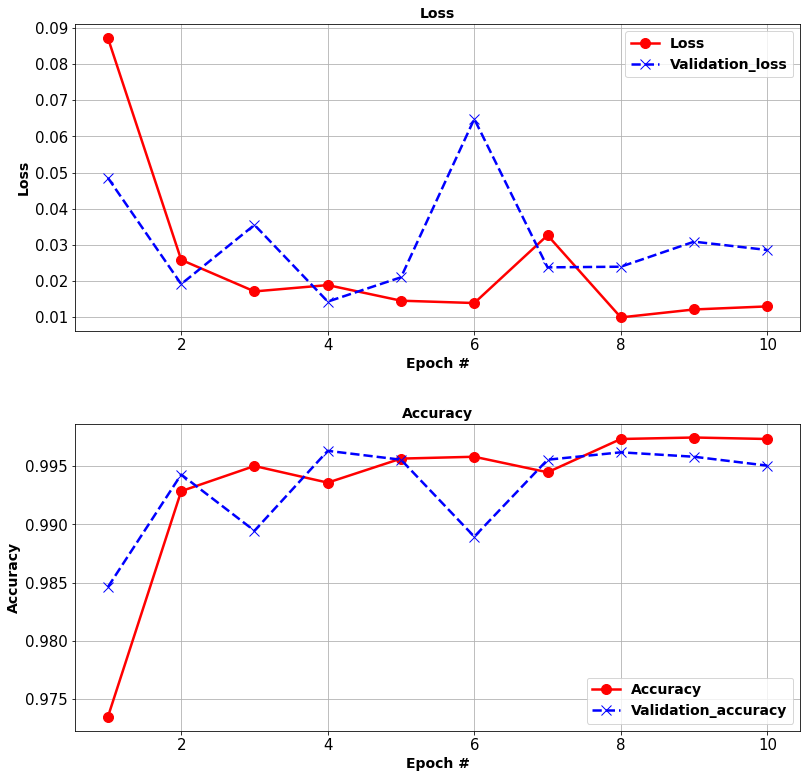

In [66]:
#Plot results of training
plot_training(res_first_classification, 'KerasModel', layers_len)

### Final Model

In [47]:
#Grab length of layers for plotting
final_layers_len = len(final_model.layers)

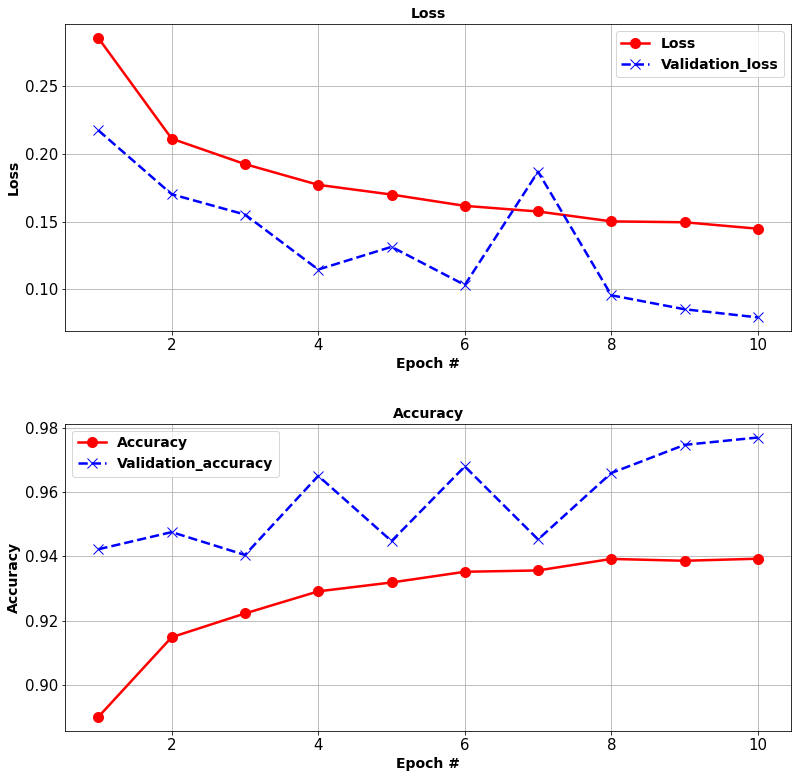

In [59]:
#Plot results of training
plot_training(res_final_classification, 'KerasModel', final_layers_len)

## Evaluating Results of Models on Test
### Import and Prepare Dataset
As before, we need to establish a local test directory before loading the image dataset.

In [74]:
## Set current TEST directory - OVERALL
local_test_dir = "C:\\Users\\ConnorRoth\\Documents\\Grad School\\Spring 2023\\DSCI 591\\Datasets\\FLAME 1\\Test"

In [75]:
## Grab the datset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_test_dir, seed=1337, image_size=image_size, batch_size=32, shuffle=True
    )

Found 8617 files belonging to 2 classes.


### Test Function Definition

In [96]:
### General Test Function Definition
def test_classification(test_ds, model):
    results_eval = model.evaluate(test_ds, batch_size=32)

    for name, value in zip(model.metrics_names, results_eval):
        print(name, ': ', value)
    print()

    return results_eval

### Model Evaluation

#### First Model

In [99]:
first_model = load_model(file_first_model_classification)

first_model_results = test_classification(test_ds, first_model)

270/270 [==============================] - 33s 123ms/step - loss: 7.3049 - accuracy: 0.4237
loss :  7.304928302764893
accuracy :  0.4236973524093628



#### Final Model

In [100]:
final_model = load_model(file_final_model_classification)

final_model_results = test_classification(test_ds, final_model)

270/270 [==============================] - 20s 74ms/step - loss: 1.2040 - accuracy: 0.5806
loss :  1.2039988040924072
accuracy :  0.5805965065956116

